<a href="https://colab.research.google.com/github/NikkiYng/EX3_NLP/blob/main/Cityname_generator_Tensorflow_RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# City Name Generation using RNN
Generate latin script and non-latin script names using a GRU network.

In [ ]:
import tensorflow as tf
from numpy.random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output
import random
from random import sample
import pickle
import sys

from keras.layers import Embedding, Dense, Concatenate
import keras
import keras.layers as L
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.models import Sequential, load_model


##  Data prepration

**1. Download data**

In [ ]:
# Download csv files
!wget https://raw.githubusercontent.com/NikkiYng/EX3_NLP/main/china_cities.csv
cncities = pd.read_csv("china_cities.csv")
print(cncities[:5])

!wget https://raw.githubusercontent.com/NikkiYng/EX3_NLP/main/uscities.csv
uscities = pd.read_csv("uscities.csv")
print(uscities[:5])

--2024-03-31 18:08:43--  https://raw.githubusercontent.com/NikkiYng/EX3_NLP/main/china_cities.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300500 (293K) [text/plain]
Saving to: ‘china_cities.csv’

china_cities.csv    100%[===================>] 293.46K  --.-KB/s    in 0.01s   

2024-03-31 18:08:44 (25.0 MB/s) - ‘china_cities.csv’ saved [300500/300500]

       城市/地区编码        英文  中文 国家代码   国家英文 国家中文      省英文 省中文  所属上级市英文 所属上级市中文  \
0  CN101010100   beijing  北京   CN  China   中国  beijing  北京  beijing      北京   
1  CN101010200   haidian  海淀   CN  China   中国  beijing  北京  beijing      北京   
2  CN101010300  chaoyang  朝阳   CN  China   中国  beijing  北京  beijing      北京   
3  CN101010400    shunyi  顺义   CN  China   中国  beijing  北京  beijing      北京   
4  CN1010105

**2. Data Cleaning**

In [ ]:
# Chinese City Names
cncities = cncities['中文'].drop_duplicates() # only keep the column with city names

# From csv to txt
file_name = 'cn.txt' # switch from csv to txt
with open(file_name, 'w') as file:
    for item in cncities:
        file.write(str(item) + '\n')

# Convert to numpy array
def load_data(filename):
    with open(filename, 'r') as f:
        data = f.read().lower().split('\n')
    return np.array(data)


cncities = load_data('cn.txt')
print("examples:", cncities)
print(type(cncities))
print("number:",len(cncities))

examples: ['北京' '海淀' '朝阳' ... '花莲' '云林' '']
<class 'numpy.ndarray'>
number: 3094


In [ ]:
# American City Names

# Clean up some of the special characters
def replace_special_chars(char):
    replace = {',': '', '1': '', '2': '', '5': '', '6': '', '7': '', 'á': 'a', 'é': 'e', 'í': 'i', 'ñ': 'n', 'ó': 'o', 'ú': 'u', 'ü': 'u'}
    return replace[char] if char in replace else char

uscities = uscities['city'].map(lambda word: ''.join([replace_special_chars(char) for char in word]))

uscities = uscities.drop_duplicates()[:3093] # match the number of the cncities

# Switch from csv to txt
file_name2 = 'us.txt'
with open(file_name2, 'w') as file:
    for item in uscities:
        file.write(str(item) + '\n')

uscities = load_data('us.txt')
print("examples:", uscities)
print(type(uscities))
print("number:",len(uscities))

examples: ['new york' 'los angeles' 'chicago' ... 'minden' 'grantsville' '']
<class 'numpy.ndarray'>
number: 3094


**3. Spliting dataset**

In [ ]:
# CN: prepare the data splits: training, validation, testing
random.seed(42)
random.shuffle(cncities)
n3 = int(0.8*len(cncities))
n4 = int(0.9*len(cncities))

cn_train = cncities[:n3]
cn_val = cncities[n3:n4]
cn_test = cncities[n4:]

print("cn data:")
print(len(cn_train))
print(len(cn_val))
print(len(cn_test))
print("")
# US: prepare the data splits: training, validation, testing
random.seed(42)
random.shuffle(uscities)
n1 = int(0.8*len(uscities))
n2 = int(0.9*len(uscities))

us_train = uscities[:n1]
us_val = uscities[n1:n2]
us_test = uscities[n2:]

print("us data:")
print(len(us_train))
print(len(us_val))
print(len(us_test))

cn data:
2475
309
310

us data:
2475
309
310


## Text Processing
**1. Create a vocabulary dictionary**

In [ ]:
print("Chinese city names")

# Find the unique characters for the vocabulary
vocab_tokens = ['#'] + list(set(''.join(cncities))) #  Here '#' means End of Sentence
vocab_tokens_len = len(vocab_tokens)
print(vocab_tokens)
print("Character number:", vocab_tokens_len)
# Find the max length amongst names
max_name_len = max(len(name) for name in cn_train)
print('Max length: ', max_name_len)

Chinese city names
['#', '圩', '萝', '郊', '猇', '邳', '楚', '芷', '浩', '化', '惠', '班', '得', '真', '贝', '政', '环', '琼', '弥', '蒗', '音', '邡', '云', '贞', '金', '社', '魏', '瓦', '钓', '叙', '锋', '扬', '石', '阆', '涡', '零', '潮', '旌', '伽', '霞', '顺', '舟', '小', '孙', '将', '瑞', '广', '晋', '清', '碑', '伯', '鲁', '庄', '钦', '禹', '洛', '蓥', '祝', '澧', '逊', '韶', '斯', '端', '濮', '峻', '觉', '芒', '年', '资', '郁', '仔', '坻', '齐', '集', '汨', '布', '离', '歙', '遵', '足', '册', '乳', '碧', '巴', '忻', '荫', '恭', '点', '明', '月', '东', '迎', '孟', '精', '枝', '勐', '圳', '邗', '山', '衢', '棣', '嫩', '后', '保', '留', '芗', '洋', '崃', '峄', '沁', '特', '简', '附', '雍', '邱', '涉', '繁', '门', '敦', '爱', '名', '扎', '贤', '启', '项', '磁', '野', '坂', '盂', '仆', '朐', '乃', '宛', '乐', '青', '八', '革', '左', '勉', '行', '信', '蔡', '鼎', '曙', '汤', '麓', '邺', '洪', '莒', '晏', '郑', '浏', '带', '瓯', '赵', '票', '凭', '阁', '穆', '澳', '七', '容', '婺', '王', '水', '师', '尔', '岭', '壤', '屿', '铜', '管', '妃', '迈', '相', '綦', '郾', '富', '芦', '鹤', '立', '千', '缙', '鄄', '福', '江', '扶', '等', '巨', '宕', '始', '鸠', '浑', '厢', '察', '邵', 

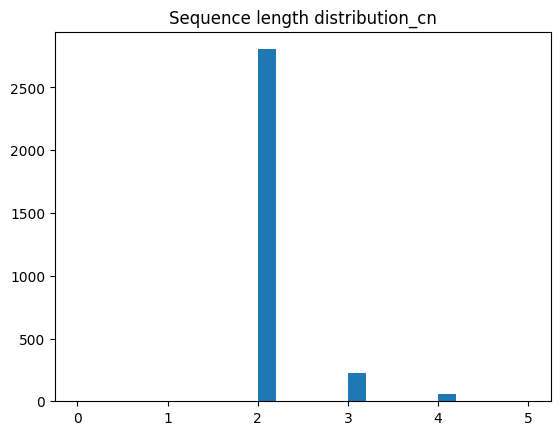

In [ ]:
plt.title('Sequence length distribution_cn')
plt.hist(list(map(len, cncities)), bins=25);

In [ ]:
print("American city names")
vocab_tokens2 = ['#'] + list(set(''.join(uscities))) #  Here '#' means End of Sentence
vocab_tokens_len2 = len(vocab_tokens2)
print(vocab_tokens2)
print("Character number:", vocab_tokens_len2)
max_name_len2 = max(len(name) for name in us_train)
print('Max length: ', max_name_len2)

American city names
['#', 'j', 'd', 'c', 'l', 'z', 'o', 'p', 'b', 's', 'h', 't', 'n', '-', 'v', ' ', 'w', 'x', 'y', "'", 'q', 'f', 'm', 'i', 'g', 'u', '.', 'k', 'r', 'e', 'a']
Character number: 31
Max length:  27


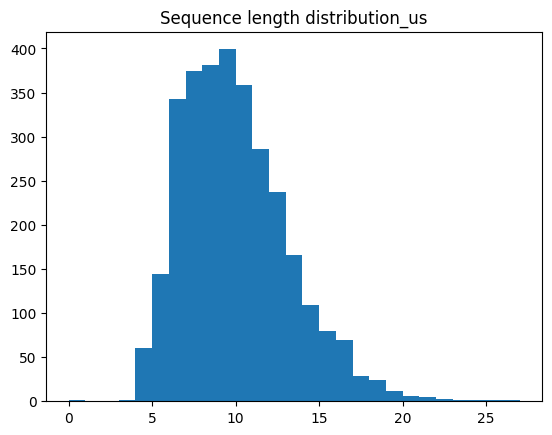

In [ ]:
plt.title('Sequence length distribution_us')
plt.hist(list(map(len, uscities)), bins=27);

**2. Create a dictionary mapping of characters to indices and vice-versa**

In [ ]:
# character to index cn
ch_to_idx = {ch:idx for idx, ch in enumerate(vocab_tokens)}
print('\nDict len: ', len(ch_to_idx))
print(ch_to_idx)

# index to chracter cn
idx_to_ch = {ch_to_idx[ch]:ch for ch in ch_to_idx.keys()}
print('\nDict len: ', len(idx_to_ch))
print(idx_to_ch)

# character to index us
ch_to_idx2 = {ch:idx for idx, ch in enumerate(vocab_tokens2)}
print('\nDict len: ', len(ch_to_idx2))
print(ch_to_idx2)

# index to chracter us
idx_to_ch2 = {ch_to_idx2[ch]:ch for ch in ch_to_idx2.keys()}
print('\nDict len: ', len(idx_to_ch2))
print(idx_to_ch2)


Dict len:  1212
{'#': 0, '圩': 1, '萝': 2, '郊': 3, '猇': 4, '邳': 5, '楚': 6, '芷': 7, '浩': 8, '化': 9, '惠': 10, '班': 11, '得': 12, '真': 13, '贝': 14, '政': 15, '环': 16, '琼': 17, '弥': 18, '蒗': 19, '音': 20, '邡': 21, '云': 22, '贞': 23, '金': 24, '社': 25, '魏': 26, '瓦': 27, '钓': 28, '叙': 29, '锋': 30, '扬': 31, '石': 32, '阆': 33, '涡': 34, '零': 35, '潮': 36, '旌': 37, '伽': 38, '霞': 39, '顺': 40, '舟': 41, '小': 42, '孙': 43, '将': 44, '瑞': 45, '广': 46, '晋': 47, '清': 48, '碑': 49, '伯': 50, '鲁': 51, '庄': 52, '钦': 53, '禹': 54, '洛': 55, '蓥': 56, '祝': 57, '澧': 58, '逊': 59, '韶': 60, '斯': 61, '端': 62, '濮': 63, '峻': 64, '觉': 65, '芒': 66, '年': 67, '资': 68, '郁': 69, '仔': 70, '坻': 71, '齐': 72, '集': 73, '汨': 74, '布': 75, '离': 76, '歙': 77, '遵': 78, '足': 79, '册': 80, '乳': 81, '碧': 82, '巴': 83, '忻': 84, '荫': 85, '恭': 86, '点': 87, '明': 88, '月': 89, '东': 90, '迎': 91, '孟': 92, '精': 93, '枝': 94, '勐': 95, '圳': 96, '邗': 97, '山': 98, '衢': 99, '棣': 100, '嫩': 101, '后': 102, '保': 103, '留': 104, '芗': 105, '洋': 106, '崃': 107, '峄': 108, '沁

In [ ]:
# Convert string names to matrix representation consisting of numerical indices
# output shape: (m, Tx)
def to_num_matrix(names, ch_to_idx):

    max_len = max(map(len, names))
    names_idx = np.zeros((len(names), max_len), dtype='int32')

    for i, name in enumerate(names):
        for j, ch in enumerate(name):
            names_idx[i][j] = ch_to_idx[ch]

    return names_idx

In [ ]:
print("Cncities:")
print(to_num_matrix(cn_train, ch_to_idx).shape)
print(to_num_matrix(cn_val, ch_to_idx).shape)
print(to_num_matrix(cn_test, ch_to_idx).shape)
print("")
print("Uscities:")
print(to_num_matrix(us_train, ch_to_idx2).shape)
print(to_num_matrix(us_val, ch_to_idx2).shape)
print(to_num_matrix(us_test, ch_to_idx2).shape)

Cncities:
(2475, 5)
(309, 5)
(310, 4)

Uscities:
(2475, 27)
(309, 24)
(310, 22)


## Model Training- cn
**1. Build the model**

In [ ]:
# for generating batches
def generate_model_batches(names, batch_size=32, pad=0):
    # no. of training examples
    m = np.arange(len(names))

    while True:
        # get a shuffled index list
        idx = np.random.permutation(m)

        # start yeilding batches
        for start in range(0, len(idx)-1, batch_size):
            batch_idx = idx[start:start+batch_size]
            batch_words = []

            # take out the words and tags from 'batch_size' no. of training examples
            for index in batch_idx:
                batch_words.append(names[index])

            # input x
            batch_x = to_num_matrix(batch_words, ch_to_idx)

            # output labels
            batch_y_ohe = to_categorical(batch_x[:,1:], len(vocab_tokens))
            yield batch_x[:,:-1], batch_y_ohe

**2. Fitting the model with `GRU` blocks**

In [ ]:
checkpoint = ModelCheckpoint('drive/Colab Notebooks/best_weights.h5', verbose=1, save_best_only=True)

In [ ]:
model = Sequential() # initializes a new Sequential model
model.add(L.InputLayer([None], dtype='int32'))
# Embeddings layer
model.add(L.Embedding(len(vocab_tokens), 20)) # this layer turns positive integers (indexes) into dense vectors of fixed size

# GRU layer
model.add(L.GRU(128, return_sequences=True, activation='tanh')) # adds a GRU layer with 128 units
model.add(L.Dropout(0.5)) # sets a fraction 0.5 of input units to 0 at each update during training time, which helps prevent overfitting
model.add(L.BatchNormalization()) # normalizes the activations of the previous layer at each batch

# Apply softmax
model.add(L.TimeDistributed(L.Dense(len(vocab_tokens), activation='softmax')))
# the layer above is a standard fully-connected neural network layer where each input node is connected to each output node

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          24240     
                                                                 
 gru (GRU)                   (None, None, 128)         57600     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 batch_normalization (Batch  (None, None, 128)         512       
 Normalization)                                                  
                                                                 
 time_distributed (TimeDist  (None, None, 1212)        156348    
 ributed)                                                        
                                                                 
Total params: 238700 (932.42 KB)
Trainable params: 23844

**2. Train the model**

In [ ]:
BATCH_SIZE = 256

# select optimizer
optimizer = keras.optimizers.Adam(clipvalue=1.2)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train model
hist = model.fit_generator(generate_model_batches(cn_train, batch_size=BATCH_SIZE), steps_per_epoch=len(cn_train)/BATCH_SIZE, epochs=50)

Epoch 1/50


<ipython-input-16-1c85b4caa099>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generate_model_batches(cn_train, batch_size=BATCH_SIZE), steps_per_epoch=len(cn_train)/BATCH_SIZE, epochs=50)


9/9 [==============================] - 8s 167ms/step - loss: 6.9797 - accuracy: 0.0930
Epoch 2/50
9/9 [==============================] - 1s 113ms/step - loss: 6.5113 - accuracy: 0.3144
Epoch 3/50
9/9 [==============================] - 1s 94ms/step - loss: 5.8869 - accuracy: 0.3600
Epoch 4/50
9/9 [==============================] - 1s 95ms/step - loss: 5.3862 - accuracy: 0.3627
Epoch 5/50
9/9 [==============================] - 0s 41ms/step - loss: 5.0364 - accuracy: 0.3786
Epoch 6/50
9/9 [==============================] - 1s 113ms/step - loss: 4.7672 - accuracy: 0.4351
Epoch 7/50
9/9 [==============================] - 0s 41ms/step - loss: 4.3953 - accuracy: 0.4880
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 3.9984 - accuracy: 0.5668
Epoch 9/50
9/9 [==============================] - 0s 42ms/step - loss: 3.5246 - accuracy: 0.6187
Epoch 10/50
9/9 [==============================] - 1s 59ms/step - loss: 3.0859 - accuracy: 0.6379
Epoch 11/50
9/9 [=====================

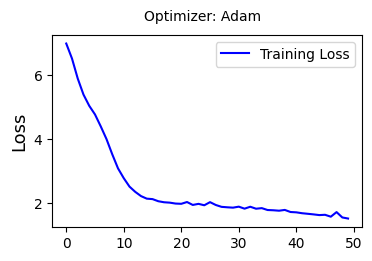

In [ ]:
# loss plot
plt.figure(figsize=(4,2.5))
plt.subplot(1,1,1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Loss', fontsize=13)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.legend(loc='upper right')
print("")

# Model Training- us

In [ ]:
# for generating batches
def generate_model_batches2(names, batch_size=32, pad=0):
    # no. of training examples
    m = np.arange(len(names))

    while True:
        # get a shuffled index list
        idx = np.random.permutation(m)

        # start yeilding batches
        for start in range(0, len(idx)-1, batch_size):
            batch_idx = idx[start:start+batch_size]
            batch_words = []

            # take out the words and tags from 'batch_size' no. of training examples
            for index in batch_idx:
                batch_words.append(names[index])

            # input x
            batch_x = to_num_matrix(batch_words, ch_to_idx2)

            # output labels
            batch_y_ohe = to_categorical(batch_x[:,1:], len(vocab_tokens2))
            yield batch_x[:,:-1], batch_y_ohe

In [ ]:
model2 = Sequential() # initializes a new Sequential model
model2.add(L.InputLayer([None], dtype='int32'))
# Embeddings layer
model2.add(L.Embedding(len(vocab_tokens2), 20)) # this layer turns positive integers (indexes) into dense vectors of fixed size

# GRU layer
model2.add(L.GRU(128, return_sequences=True, activation='tanh')) # adds a GRU layer with 128 units
model2.add(L.Dropout(0.5)) # sets a fraction 0.5 of input units to 0 at each update during training time, which helps prevent overfitting
model2.add(L.BatchNormalization()) # normalizes the activations of the previous layer at each batch

# Apply softmax
model2.add(L.TimeDistributed(L.Dense(len(vocab_tokens2), activation='softmax')))
# the layer above is a standard fully-connected neural network layer where each input node is connected to each output node

model2.summary()

# select optimizer
optimizer = keras.optimizers.Adam(clipvalue=1.2)
model2.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train model
hist2 = model2.fit_generator(generate_model_batches2(us_train, batch_size=BATCH_SIZE), steps_per_epoch=len(us_train)/BATCH_SIZE, epochs=80)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 20)          620       
                                                                 
 gru_4 (GRU)                 (None, None, 128)         57600     
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 batch_normalization_4 (Bat  (None, None, 128)         512       
 chNormalization)                                                
                                                                 
 time_distributed_4 (TimeDi  (None, None, 31)          3999      
 stributed)                                                      
                                                                 
Total params: 62731 (245.04 KB)
Trainable params: 6247

<ipython-input-41-975af59841b3>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist2 = model2.fit_generator(generate_model_batches2(us_train, batch_size=BATCH_SIZE), steps_per_epoch=len(us_train)/BATCH_SIZE, epochs=80)


9/9 [==============================] - 3s 38ms/step - loss: 3.1733 - accuracy: 0.2090
Epoch 2/80
9/9 [==============================] - 0s 6ms/step - loss: 2.4509 - accuracy: 0.4414
Epoch 3/80
9/9 [==============================] - 0s 6ms/step - loss: 2.1363 - accuracy: 0.4865
Epoch 4/80
9/9 [==============================] - 0s 16ms/step - loss: 1.8678 - accuracy: 0.5528
Epoch 5/80
9/9 [==============================] - 0s 6ms/step - loss: 1.6863 - accuracy: 0.5826
Epoch 6/80
9/9 [==============================] - 0s 6ms/step - loss: 1.5775 - accuracy: 0.5952
Epoch 7/80
9/9 [==============================] - 0s 6ms/step - loss: 1.4968 - accuracy: 0.6137
Epoch 8/80
9/9 [==============================] - 0s 6ms/step - loss: 1.4327 - accuracy: 0.6257
Epoch 9/80
9/9 [==============================] - 0s 7ms/step - loss: 1.4019 - accuracy: 0.6273
Epoch 10/80
9/9 [==============================] - 0s 6ms/step - loss: 1.3536 - accuracy: 0.6341
Epoch 11/80
9/9 [==============================]

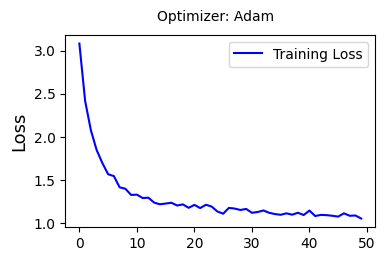

In [ ]:
# loss plot
plt.figure(figsize=(4,2.5))
plt.subplot(1,1,1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Loss', fontsize=13)
plt.plot(hist2.history['loss'], color='b', label='Training Loss')
plt.legend(loc='upper right')
print("")

# Model Evaluation

In [ ]:
# val
val1 = model.fit_generator(generate_model_batches(cn_val, batch_size=BATCH_SIZE), steps_per_epoch=len(cn_val)/BATCH_SIZE, epochs=50)

Epoch 1/50
1/1 [==============================] - 0s 43ms/step - loss: 0.3167 - accuracy: 0.9062
Epoch 2/50
1/1 [==============================] - 0s 39ms/step - loss: 0.3035 - accuracy: 0.9104
Epoch 3/50
1/1 [==============================] - 0s 40ms/step - loss: 0.3009 - accuracy: 0.9079
Epoch 4/50
1/1 [==============================] - 0s 39ms/step - loss: 0.3089 - accuracy: 0.9053
Epoch 5/50
1/1 [==============================] - 0s 37ms/step - loss: 0.3031 - accuracy: 0.9062
Epoch 6/50
1/1 [==============================] - 0s 37ms/step - loss: 0.3587 - accuracy: 0.9044


<ipython-input-37-3fe884616f49>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  val1 = model.fit_generator(generate_model_batches(cn_val, batch_size=BATCH_SIZE), steps_per_epoch=len(cn_val)/BATCH_SIZE, epochs=50)


Epoch 7/50
1/1 [==============================] - 0s 37ms/step - loss: 0.3107 - accuracy: 0.9115
Epoch 8/50
1/1 [==============================] - 0s 38ms/step - loss: 0.2711 - accuracy: 0.9172
Epoch 9/50
1/1 [==============================] - 0s 39ms/step - loss: 0.3249 - accuracy: 0.9115
Epoch 10/50
1/1 [==============================] - 0s 38ms/step - loss: 0.2609 - accuracy: 0.9138
Epoch 11/50
1/1 [==============================] - 0s 38ms/step - loss: 0.2628 - accuracy: 0.9138
Epoch 12/50
1/1 [==============================] - 0s 39ms/step - loss: 0.2482 - accuracy: 0.9146
Epoch 13/50
1/1 [==============================] - 0s 38ms/step - loss: 0.2395 - accuracy: 0.9222
Epoch 14/50
1/1 [==============================] - 0s 40ms/step - loss: 0.2454 - accuracy: 0.9155
Epoch 15/50
1/1 [==============================] - 0s 37ms/step - loss: 0.2357 - accuracy: 0.9214
Epoch 16/50
1/1 [==============================] - 0s 40ms/step - loss: 0.2787 - accuracy: 0.9150
Epoch 17/50
1/1 [======

In [ ]:
# test
val2 = model.fit_generator(generate_model_batches(cn_test, batch_size=BATCH_SIZE), steps_per_epoch=len(cn_test)/BATCH_SIZE, epochs=50)

Epoch 1/50
1/1 [==============================] - 0s 46ms/step - loss: 1.2532 - accuracy: 0.7559
Epoch 2/50
1/1 [==============================] - 0s 42ms/step - loss: 1.2038 - accuracy: 0.7581
Epoch 3/50
1/1 [==============================] - 0s 44ms/step - loss: 1.2820 - accuracy: 0.7409
Epoch 4/50
1/1 [==============================] - 0s 39ms/step - loss: 1.0995 - accuracy: 0.7742
Epoch 5/50
1/1 [==============================] - 0s 40ms/step - loss: 1.0936 - accuracy: 0.7705
Epoch 6/50
1/1 [=======================>......] - ETA: 0s - loss: 0.8927 - accuracy: 0.7786

<ipython-input-38-9237d34d990a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  val2 = model.fit_generator(generate_model_batches(cn_test, batch_size=BATCH_SIZE), steps_per_epoch=len(cn_test)/BATCH_SIZE, epochs=50)


1/1 [==============================] - 0s 45ms/step - loss: 1.0225 - accuracy: 0.7591
Epoch 7/50
1/1 [==============================] - 0s 37ms/step - loss: 0.8643 - accuracy: 0.7935
Epoch 8/50
1/1 [==============================] - 0s 45ms/step - loss: 0.8053 - accuracy: 0.7957
Epoch 9/50
1/1 [==============================] - 0s 37ms/step - loss: 0.8152 - accuracy: 0.7911
Epoch 10/50
1/1 [==============================] - 0s 37ms/step - loss: 0.7738 - accuracy: 0.7957
Epoch 11/50
1/1 [==============================] - 0s 38ms/step - loss: 0.6396 - accuracy: 0.8269
Epoch 12/50
1/1 [==============================] - 0s 39ms/step - loss: 0.6169 - accuracy: 0.8269
Epoch 13/50
1/1 [==============================] - 0s 37ms/step - loss: 0.5806 - accuracy: 0.8591
Epoch 14/50
1/1 [==============================] - 0s 38ms/step - loss: 0.5435 - accuracy: 0.8516
Epoch 15/50
1/1 [==============================] - 0s 40ms/step - loss: 0.6079 - accuracy: 0.8436
Epoch 16/50
1/1 [==================

In [ ]:
# val
val2 = model2.fit_generator(generate_model_batches2(us_val, batch_size=BATCH_SIZE), steps_per_epoch=len(us_val)/BATCH_SIZE, epochs=20)

Epoch 1/20
1/1 [==============================] - 0s 47ms/step - loss: 0.7940 - accuracy: 0.7522
Epoch 2/20
1/1 [==============================] - 0s 40ms/step - loss: 0.8455 - accuracy: 0.7396
Epoch 3/20
1/1 [==============================] - 0s 40ms/step - loss: 0.7809 - accuracy: 0.7563
Epoch 4/20
1/1 [==============================] - 0s 41ms/step - loss: 0.8627 - accuracy: 0.7412
Epoch 5/20
1/1 [==============================] - 0s 45ms/step - loss: 0.7845 - accuracy: 0.7553
Epoch 6/20
1/1 [==============================] - 0s 39ms/step - loss: 0.7955 - accuracy: 0.7526
Epoch 7/20
1/1 [==============================] - 0s 40ms/step - loss: 0.8301 - accuracy: 0.7452
Epoch 8/20


<ipython-input-33-564ebc01d6ea>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  val2 = model2.fit_generator(generate_model_batches2(us_val, batch_size=BATCH_SIZE), steps_per_epoch=len(us_val)/BATCH_SIZE, epochs=20)


1/1 [==============================] - 0s 39ms/step - loss: 0.7797 - accuracy: 0.7605
Epoch 9/20
1/1 [==============================] - 0s 38ms/step - loss: 0.8325 - accuracy: 0.7482
Epoch 10/20
1/1 [==============================] - 0s 39ms/step - loss: 0.7819 - accuracy: 0.7556
Epoch 11/20
1/1 [==============================] - 0s 41ms/step - loss: 0.7872 - accuracy: 0.7563
Epoch 12/20
1/1 [==============================] - 0s 39ms/step - loss: 0.8400 - accuracy: 0.7454
Epoch 13/20
1/1 [==============================] - 0s 38ms/step - loss: 0.8423 - accuracy: 0.7454
Epoch 14/20
1/1 [==============================] - 0s 40ms/step - loss: 0.8183 - accuracy: 0.7490
Epoch 15/20
1/1 [==============================] - 0s 40ms/step - loss: 0.8192 - accuracy: 0.7481
Epoch 16/20
1/1 [==============================] - 0s 40ms/step - loss: 0.8578 - accuracy: 0.7392
Epoch 17/20
1/1 [==============================] - 0s 41ms/step - loss: 0.7649 - accuracy: 0.7599
Epoch 18/20
1/1 [================

In [ ]:
# test
test2 = model2.fit_generator(generate_model_batches2(us_val, batch_size=BATCH_SIZE), steps_per_epoch=len(us_val)/BATCH_SIZE, epochs=20)

Epoch 1/20
1/1 [==============================] - 0s 53ms/step - loss: 0.8414 - accuracy: 0.7389
Epoch 2/20
1/1 [==============================] - 0s 46ms/step - loss: 0.7847 - accuracy: 0.7523
Epoch 3/20
1/1 [==============================] - 0s 39ms/step - loss: 0.8151 - accuracy: 0.7518
Epoch 4/20
1/1 [==============================] - 0s 39ms/step - loss: 0.7792 - accuracy: 0.7542
Epoch 5/20
1/1 [==============================] - 0s 42ms/step - loss: 0.8151 - accuracy: 0.7489
Epoch 6/20
1/1 [==============================] - 0s 41ms/step - loss: 0.7729 - accuracy: 0.7568
Epoch 7/20
1/1 [==============================] - 0s 38ms/step - loss: 0.7656 - accuracy: 0.7597
Epoch 8/20


<ipython-input-34-80edcff1dc8f>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  test2 = model2.fit_generator(generate_model_batches2(us_val, batch_size=BATCH_SIZE), steps_per_epoch=len(us_val)/BATCH_SIZE, epochs=20)


1/1 [==============================] - 0s 39ms/step - loss: 0.7850 - accuracy: 0.7528
Epoch 9/20
1/1 [==============================] - 0s 40ms/step - loss: 0.7659 - accuracy: 0.7611
Epoch 10/20
1/1 [==============================] - 0s 40ms/step - loss: 0.8212 - accuracy: 0.7500
Epoch 11/20
1/1 [==============================] - 0s 39ms/step - loss: 0.7798 - accuracy: 0.7518
Epoch 12/20
1/1 [==============================] - 0s 38ms/step - loss: 0.8086 - accuracy: 0.7519
Epoch 13/20
1/1 [==============================] - 0s 39ms/step - loss: 0.7757 - accuracy: 0.7546
Epoch 14/20
1/1 [==============================] - 0s 37ms/step - loss: 0.8025 - accuracy: 0.7545
Epoch 15/20
1/1 [==============================] - 0s 39ms/step - loss: 0.7806 - accuracy: 0.7550
Epoch 16/20
1/1 [==============================] - 0s 37ms/step - loss: 0.8017 - accuracy: 0.7498
Epoch 17/20
1/1 [==============================] - 0s 37ms/step - loss: 0.7935 - accuracy: 0.7515
Epoch 18/20
1/1 [================

## Sample Text
Generate new names by feeding a seed input.

In [ ]:
# samples text from language model
def sample_text(seed_phrase='a', max_length=max_name_len):


    # input x to numerical index
    text_x = to_num_matrix(list(list(seed_phrase)), ch_to_idx)
    # index of current character
    ch = ch_to_idx[seed_phrase]

    # list of predicted character indices
    indices = []
    # counter
    i = 0

    #start generating
    while ch != 0 and i<max_length:
        # predict using the input character
        pred = model.predict(text_x)[0]

        # get the char with highest prob.
        ch = np.random.choice(np.arange(len(vocab_tokens)) , p = pred.ravel())

        if ch!=0:
            indices.append(ch)

        # feed the current char as the next input
        text_x = to_num_matrix(list(list(idx_to_ch[ch])), ch_to_idx)

        i = i+ 1


    return ''.join([idx_to_ch[idx] for idx in indices])


i = 0
while i < 10:
    name = sample_text('南', max_length=2)
    if name != '':
        print(name)
        i += 1

1/1 [==============================] - 0s 20ms/step
许曲
1/1 [==============================] - 0s 19ms/step
甸夏
1/1 [==============================] - 0s 20ms/step
仁屏
1/1 [==============================] - 0s 19ms/step
休谷
1/1 [==============================] - 0s 19ms/step
饶中
1/1 [==============================] - 0s 20ms/step
戴州
1/1 [==============================] - 0s 20ms/step
齐江
1/1 [==============================] - 0s 20ms/step
和丹
1/1 [==============================] - 0s 19ms/step
朔松
1/1 [==============================] - 0s 19ms/step
场多


In [ ]:
# samples text from language model
def sample_text2(seed_phrase='a', max_length=max_name_len):


    # input x to numerical index
    text_x = to_num_matrix(list(list(seed_phrase)), ch_to_idx2)
    # index of current character
    ch = ch_to_idx2[seed_phrase]

    # list of predicted character indices
    indices = []
    # counter
    i = 0

    #start generating
    while ch != 0 and i<max_length:
        # predict using the input character
        pred = model2.predict(text_x)[0]

        # get the char with highest prob.
        ch = np.random.choice(np.arange(len(vocab_tokens2)) , p = pred.ravel())

        if ch!=0:
            indices.append(ch)

        # feed the current char as the next input
        text_x = to_num_matrix(list(list(idx_to_ch2[ch])), ch_to_idx2)

        i = i+ 1


    return ''.join([idx_to_ch2[idx] for idx in indices])


i = 0
while i < 10:
    name = sample_text2('b', max_length=9)
    if name != '':
        print(name)
        i += 1

1/1 [==============================] - 0s 20ms/step
erilorree
1/1 [==============================] - 0s 19ms/step
ewamaleli
1/1 [==============================] - 0s 19ms/step
aloewiler
1/1 [==============================] - 0s 19ms/step
adetooror
1/1 [==============================] - 0s 19ms/step
ukaohibra
1/1 [==============================] - 0s 19ms/step
relaucoou
1/1 [==============================] - 0s 20ms/step
ucoraweva
1/1 [==============================] - 0s 20ms/step
oonioroka
1/1 [==============================] - 0s 19ms/step
lanorha o
1/1 [==============================] - 0s 20ms/step
raronoein
